# BEN_tutorial_Ⅰ
Note: to replicate experiments conveniently, we did not package key functions as '.exe' files here. Preprocessing is also simplified.

---
<font size=5>Table of Contents</font>

* [1.0 Set up](#1.0)
  * [1.1 Verify Runtime Settings](#1.1)
  * [1.2 Set up environment and install all necessary packages](#1.2)
  * [1.3 Download code from github](#1.3)
  * [1.4 Download MRI data](#1.4)
* [2.0 Cross species (Mouse -> Rat)](#2.0)
  * [2.1 Declare key function and path](#2.1)
  * [2.2.1 Run baseline methods domain transfer/adaptation](#2.2.1)
  * [2.2.2 Run BEN's domain transfer/adaptation](#2.2.2)
  * [2.3 Visualize the output](#2.3)
  * [2.4 (Optional) Simple postprocessing](#2.4)
* [3.0 Conclusion](#4.0)
* [4.0 (Optional) Download new weight](#4.0)

---



<a name='1.0'></a>
# 1.0 Set up

<a name='1.1'></a>
## 1.1 Verify Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU 

See your Hardware Accelerator in Edit/Notebook settings in Colab Menu(On the upper left usually).

<a name='1.2'></a>
## 1.2 Set up environment and install all necessary packages

After installation, you might **<font color='#FF000'> need to restart </font>** the runtime in order to use newly installed versions (Tensorflow 1.15).



In [ ]:
!pip install SimpleITK tensorflow-gpu==1.15.4 keras==2.2.4 h5py==2.10 scikit-image==0.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<a name='1.3'></a>

## 1.3 Download code from github.

In [ ]:
!git clone https://github.com/yu02019/BEN.git

Cloning into 'BEN'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 162 (delta 2), reused 10 (delta 0), pack-reused 143
Receiving objects: 100% (162/162), 6.47 MiB | 31.56 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [ ]:
cd BEN

/content/BEN


<a name='1.4'></a>
## 1.4 Download MRI data.

Note: todo: add

In [ ]:
!gdown --id 1fmyBtxNJAYFtlwVBY5IiFsmUixc2MsU9
!sh download.sh

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fmyBtxNJAYFtlwVBY5IiFsmUixc2MsU9
To: /content/BEN/download.sh
100% 273/273 [00:00<00:00, 510kB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z-VMfPvFILNcaEc9jSYzcnub7t4ZcrfJ
To: /content/BEN/cross_domain/cross_domain.zip
100% 26.8M/26.8M [00:00<00:00, 144MB/s] 
Archive:  cross_domain.zip
   creating: 7T/
   creating: 7T/src/
  inflating: 7T/src/20171226_185416T1RAREs30001a001.nii.gz  
  inflating: 7T/src/20180321_133106T2TurboRAREs20001a001.nii.gz  
  inflating: 7T/src/20180510_143551

The MRI data look like: 

(src: raw MRI scans; label:ground truth)


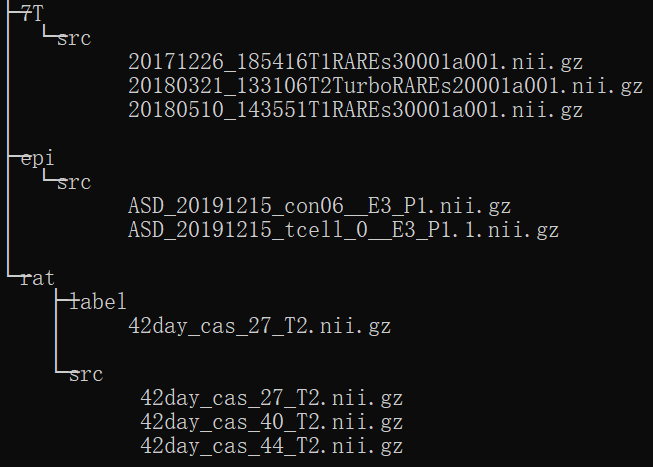

In [ ]:
import os
import logging
import warnings
import tensorflow as tf

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # tf log errors only
logging.getLogger('tensorflow').setLevel(logging.ERROR)
print(tf.__version__)

1.15.4


<a name='2.0' ></a>
# 2.0 Cross species (Mouse -> Rat)
In this case, only **ONE** label is required.

<a name='2.1'></a>
## 2.1 Declare key function and path


In [ ]:
from utils.update_model import update_weight

# input (3 or more MRI scan)
input_folder = r'cross_domain/rat/src'
# label (use 1 label in this task)
label_folder = r'cross_domain/rat/label'

output_folder_base = os.path.dirname(input_folder)  # save pred nii files.(time id based on weight)
cvs_result_base = r'cross_domain/rat'  # folder path. Evaluation metric in csv. (path of csv, time id)
need_rotate = True  # always use Ture
source_domain_weight = 'weight/unet_fp32_all_BN_NoCenterScale_polyic_epoch15_bottle256_04012056/'  # load and adjust BN base on this old model(fixed/source domain usually)
new_model_name_prefix = 'Rat-42d-2022'  # The prefix of new weight filename will use this string

In [ ]:
def run_main(
        BN_list=None,
        droprate=None,
        new_model_name='unet_temp',
        weight=None,
        max_num=-1,
        freeze=True,
        momentum=0.99,
        epochs=15,
):
    new_weight = update_weight(input_folder, label_folder, need_mkdir=True, weight=weight, need_rotate=need_rotate,
                                model_name=new_model_name, BN_list=BN_list, droprate=droprate, freeze=freeze,
                                momentum=momentum, epochs=epochs, max_num=max_num)
    print('Finetune done.\n New model path is : ', new_weight)
    
    ''' setting filename '''
    import re
    num_extract = re.findall(r'\d+', new_weight)

    output_folder = output_folder_base + '/' + 'pred' + '-' + str(new_model_name)  # e.g. 'pred-04061444'
    cvs_result = cvs_result_base + '/' + os.path.basename(output_folder) + '.csv'

    new_weight = new_weight + '.hdf5'

    ''' infer and compute csv'''
    ''' infer whole folder '''
    from utils.inference import inference_pipeline
    import tensorflow.keras.backend as K
    K.clear_session()  # release GRAM

    inference_pipeline(input_folder, output_folder, is_mkdir=True, weight=new_weight, need_rotate=need_rotate,
                        BN_list=BN_list, droprate=droprate)
    # avoid OOM

    ''' evaluation output metrics '''
    pass

    return output_folder

<a name='2.2.1'></a>

## 2.2.1 Run baseline methods domain transfer/adaptation 

In [ ]:
num_list = [1]

# ft at 0 label (finetune with 0% cross_domain / zero-shot )
zeroshot_out_folder = run_main(BN_list=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                  new_model_name='{}-%{}-ft'.format(new_model_name_prefix, 0),
                  weight=source_domain_weight, max_num=1, freeze=False, epochs=0)
print('Done zeroshot')  # zeroshot_out_folder : 'cross_domain/rat/pred-Rat-42d-2022-%0-ft'

# ft
for num_id in num_list:
    ft_out_folder = run_main(BN_list=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                  new_model_name='{}-%{}-ft'.format(new_model_name_prefix, num_id),
                  weight=source_domain_weight, max_num=num_id, freeze=False)
print('Done ft')

Finding  3  nii.gz format files.	
Reading:	 42d_cas_27_T2.nii.gz
(50, 256, 256)
Done.
len of nii_path:	 1
Reading:	 42d_cas_27_T2.nii.gz
(50, 256, 256)
Done.

**********	Inferring CT/MRI scans:	**********

finetune all layers on target domain!


Using TensorFlow backend.


Train on 45 samples, validate on 5 samples
New model has trained and saved as:  weight/Rat-42d-2022-%0-ft_07170753/
Finetune done.
 New model path is :  weight/Rat-42d-2022-%0-ft_07170753/
Makedir:	 cross_domain/rat/pred-Rat-42d-2022-%0-ft
Object will save in (Existing) folder/print(save_filename):	 cross_domain/rat/pred-Rat-42d-2022-%0-ft
Finding  3  nii.gz format files.	
Reading:	 42d_cas_27_T2.nii.gz
(50, 256, 256)
Reading:	 42d_cas_40_T2.nii.gz
(50, 256, 256)
Reading:	 42d_cas_44_T2.nii.gz
(50, 256, 256)
Done.

**********	Inferring CT/MRI scans:	**********


**********	 3 file(s) to save: 	**********

Saving:	 (50, 256, 256)
Saving:	 (50, 256, 256)
Saving:	 (50, 256, 256)

**********	 Done. 	**********

Done zeroshot
Finding  3  nii.gz format files.	
Reading:	 42d_cas_27_T2.nii.gz
(50, 256, 256)
Done.
len of nii_path:	 1
Reading:	 42d_cas_27_T2.nii.gz
(50, 256, 256)
Done.

**********	Inferring CT/MRI scans:	**********

finetune all layers on target domain!
Train on 45 samples, vali

<a name='2.2.2'></a>
## 2.2.2 Run BEN's domain transfer/adaptation

In [ ]:
# DA (domain adaptation using BEN's AdaBN)
for num_id in num_list:
    DA_out_folder = run_main(BN_list=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                  new_model_name='{}-%{}-DA'.format(new_model_name_prefix, num_id),
                  weight=source_domain_weight, max_num=num_id, freeze=True, momentum=0.8)
print('Done BEN AdaBN')

Finding  3  nii.gz format files.	
Reading:	 42d_cas_27_T2.nii.gz
(50, 256, 256)
Done.
len of nii_path:	 1
Reading:	 42d_cas_27_T2.nii.gz
(50, 256, 256)
Done.

**********	Inferring CT/MRI scans:	**********

Trainable lay:  batch_normalization_10
Trainable lay:  batch_normalization_11
Trainable lay:  batch_normalization_12
Trainable lay:  batch_normalization_13
Trainable lay:  batch_normalization_14
Trainable lay:  batch_normalization_15
Trainable lay:  batch_normalization_16
Trainable lay:  batch_normalization_17
Trainable lay:  batch_normalization_18
Trainable lay:  batch_normalization_19
Only finetune BN on target domain!
Train on 45 samples, validate on 5 samples
Epoch 1/15
45/45 [==============================] - 1s 18ms/sample - loss: 0.5112 - dice_coef: 0.5646 - val_loss: 0.2656 - val_dice_coef: 0.3957
Epoch 2/15
45/45 [==============================] - 0s 4ms/sample - loss: 0.5138 - dice_coef: 0.5647 - val_loss: 0.2340 - val_dice_coef: 0.4507
Epoch 3/15
45/45 [===================

<a name='2.3'></a>
## 2.3 Visualize the output
### For fair comparision, we download ground truth here after finishing training for plotting.
Ground truth will be saved at '/content/BEN/cross_domain/rat/gt/' (click to jump to this folder after running the following cell)

In [ ]:
# download ground truth
!gdown --id 1aV3cZBYAwtdiDcW04q1Z2lz7AelobJqb
!sh download_gt.sh

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1aV3cZBYAwtdiDcW04q1Z2lz7AelobJqb
To: /content/BEN/download_gt.sh
100% 146/146 [00:00<00:00, 264kB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1EHNors0X7C-BoY2OgrSeV-OFAluN8YhS
To: /content/BEN/cross_domain/gt.zip
100% 49.1k/49.1k [00:00<00:00, 58.2MB/s]
Archive:  gt.zip
  inflating: 42d_cas_27_T2.nii.gz    
  inflating: 42d_cas_40_T2.nii.gz    
  inflating: 42d_cas_44_T2.nii.gz    


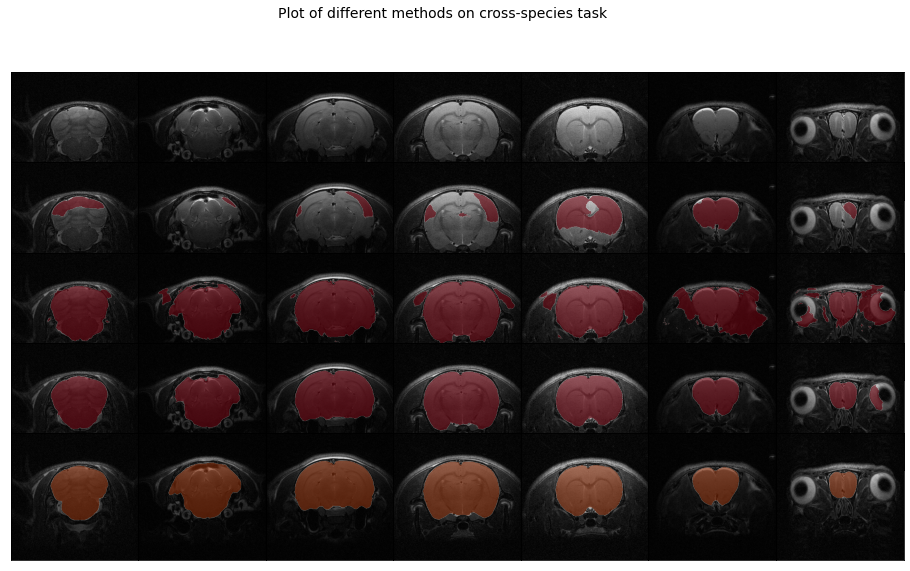

In [ ]:
''' cross species '''
from glob import glob
from utils.load_data import get_itk_array
from utils.visualization import load_slice_cross_species, plot_segmentation_cross_species

raw, zeroshot, ft, DA, gt = load_slice_cross_species(raw_path=r'cross_domain/rat/src',
                              zeroshot_path=r'cross_domain/rat/pred-Rat-42d-2022-%0-ft',
                              ft_path=r'cross_domain/rat/pred-Rat-42d-2022-%1-ft',
                              DA_path=r'cross_domain/rat/pred-Rat-42d-2022-%1-DA',
                              gt_path=r'cross_domain/rat/gt', scans_num=2)
plot_segmentation_cross_species(raw, zeroshot, ft, DA, gt, task='species', hspace=-0.3, figsize=(16,9))

From top raw to the fifth raw: **<font color='#A5A5A5'> *Raw image* </font>**, **<font color='#FF0000'> Zero-shot </font>** (0 label used), **<font color='#FF0000'> finetune </font>** (1 label used), **<font color='#FF0000'> BEN's </font>** result (1 label used), and **<font color='#ED7D31'> Ground truth </font>**.




<a name='2.4'></a>
## 2.4 (Optional) Simple postprocessing
Just do some simple postprocessing here, e.g., only save the top-K largest connected regions. (K=1 in brain extraction)

In [ ]:
from utils.postprocess import remove_small_objects

# ft postprocessing
remove_small_objects(input_path=r'cross_domain/rat/pred-Rat-42d-2022-%1-ft', output_path=r'cross_domain/rat/pred-Rat-42d-2022-%1-ft-post')
# BEN postprocessing
remove_small_objects(input_path=r'cross_domain/rat/pred-Rat-42d-2022-%1-DA', output_path=r'cross_domain/rat/pred-Rat-42d-2022-%1-DA-post')

Makedir:	 cross_domain/rat/pred-Rat-42d-2022-%1-ft-post
Object will save in (Existing) folder/print(save_filename):	 cross_domain/rat/pred-Rat-42d-2022-%1-ft-post
matrix shape:	 (50, 256, 256)
matrix shape:	 (50, 256, 256)
matrix shape:	 (50, 256, 256)
Makedir:	 cross_domain/rat/pred-Rat-42d-2022-%1-DA-post
Object will save in (Existing) folder/print(save_filename):	 cross_domain/rat/pred-Rat-42d-2022-%1-DA-post
matrix shape:	 (50, 256, 256)
matrix shape:	 (50, 256, 256)
matrix shape:	 (50, 256, 256)


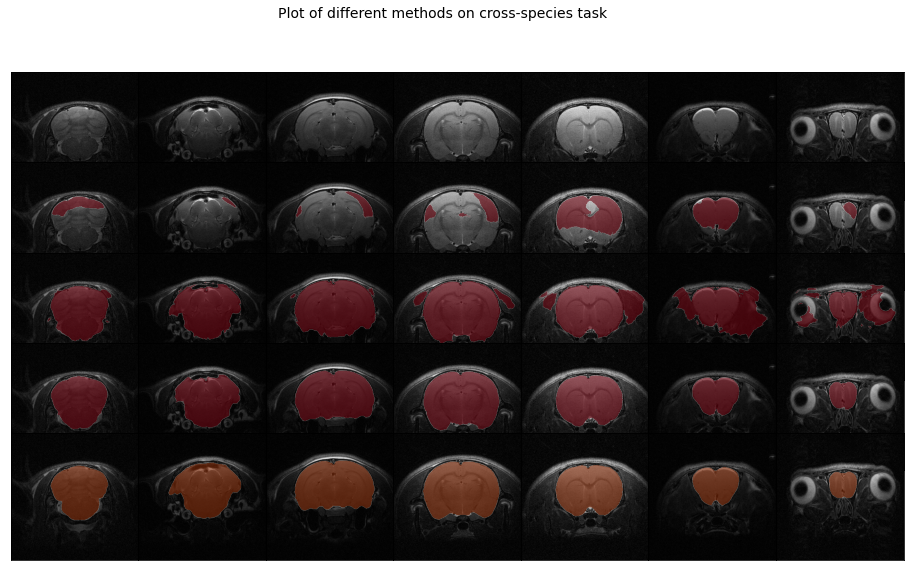

In [ ]:
''' cross species - postprocessing '''
raw, zeroshot, ft, DA, gt = load_slice_cross_species(raw_path=r'cross_domain/rat/src',
                              zeroshot_path=r'cross_domain/rat/pred-Rat-42d-2022-%0-ft',
                              ft_path=r'cross_domain/rat/pred-Rat-42d-2022-%1-ft-post',
                              DA_path=r'cross_domain/rat/pred-Rat-42d-2022-%1-DA-post',
                              gt_path=r'cross_domain/rat/gt', scans_num=2)
plot_segmentation_cross_species(raw, zeroshot, ft, DA, gt, task='species', hspace=-0.3, figsize=(16,9))

From top raw to the fifth raw: **<font color='#A5A5A5'> *Raw image* </font>**, **<font color='#FF0000'> Zero-shot </font>** (0 label used), **<font color='#FF0000'> finetune </font>** (1 label used), **<font color='#FF0000'> BEN's </font>** result (1 label used), and **<font color='#ED7D31'> Ground truth </font>**.

Compared with other methods, it further shows BEN's advantages.




<a name='3.0'></a>
# 3.0 Conclusion

BEN shows the capacity to generalize well to other domains with minimal or even without additional labeled data, while the baseline approaches lead to abundant errors.

<a name='4.0'></a>
# 4.0 (Optional) Download new weight

After updating weight [1], BEN has already deployed on this new domain. You can download this weight to use next time without the abovementioned steps.

[1] In practice, we recommend using 4~6 target domain labels for domain adaptation. We also provide a semi-supervised or human-in-the-loop manner to deploy BEN.

In [ ]:
import os
from google.colab import files

new_weight = '{}-%{}-DA'.format(new_model_name_prefix, num_id)
new_weight_folder = glob(r'/content/BEN/weight/' + new_weight + '*')[0]
print(new_weight_folder)
os.system(f"zip -r -j download.zip {new_weight_folder}/*")
files.download("/content/BEN/weight/weight.zip")

/content/BEN/weight/Rat-42d-2022-%1-DA_07170754


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>